In [1]:
# HIDDEN

from datascience import *
path_data = '../../../data/'
import numpy as np

import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

### A/B Testing ###
In modern data analytics, deciding whether two numerical samples come from the same underlying distribution is called *A/B testing*. The name refers to the labels of the two samples, A and B.

We will develop the method in the context of an example. The data come from a sample of newborns in a large hospital system. We will treat it as if it were a simple random sample though the sampling was done in multiple stages. [Stat Labs](https://www.stat.berkeley.edu/~statlabs/) by Deborah Nolan and Terry Speed has details about a larger dataset from which this set is drawn. 

### Smokers and Nonsmokers ###
The table `baby` contains the following variables for 1,174 mother-baby pairs: the baby's birth weight in ounces, the number of gestational days, the mother's age in completed years, the mother's height in inches, pregnancy weight in pounds, and whether or not the mother smoked during pregnancy.

In [2]:
baby = Table.read_table(path_data + 'baby.csv')
baby

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


One of the aims of the study was to see whether maternal smoking was associated with birth weight. Let's see what we can say about the two variables.

We'll start by selecting just `Birth Weight` and `Maternal Smoker`. There are 715 non-smokers among the women in the sample, and 459 smokers.

In [3]:
smoking_and_birthweight = baby.select('Maternal Smoker', 'Birth Weight')

In [4]:
smoking_and_birthweight.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


Let's look at the distribution of the birth weights of the babies of the non-smoking mothers compared to those of the smoking mothers. To generate two overlaid histograms, we will use `hist` with the optional `group` argument which is a column label or index. The rows of the table are first grouped by this column and then a histogram is drawn for each one.

/home/choldgraf/anaconda/envs/dev/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


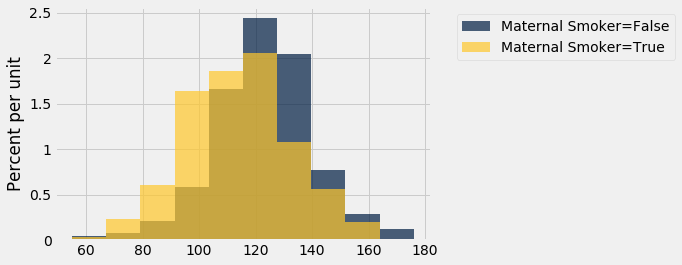

In [5]:
smoking_and_birthweight.hist('Birth Weight', group = 'Maternal Smoker')

The distribution of the weights of the babies born to mothers who smoked appears to be shifted slightly to the left of the distribution corresponding to non-smoking mothers. The weights of the babies of the mothers who smoked seem lower, on average than the weights of the babies of the non-smokers. 

This raises the question of whether the difference reflects just chance variation or a difference in the distributions in the larger population. Could it be that there is no difference between the two distributions in the population, but we are seeing a difference in the samples just because of the mothers who happened to be selected?

### The Hypotheses ###
We can try to answer this question by a test of hypotheses. The chance model that we will test says that there is no underlying difference; the distributions in the samples are different just due to chance. Formally, this is the null hypothesis.

**Null hypothesis:** In the population, the distribution of birth weights of babies is the same for mothers who don't smoke as for mothers who do. The difference in the sample is due to chance.

**Alternative hypothesis:** In the population, the babies of the mothers who smoke have a lower birth weight, on average, than the babies of the non-smokers.

### Test Statistic ###
The alternative hypothesis compares the average birth weights of the two groups and says that the average for the mothers who smoke is smaller. Therefore it is reasonable for us to use the difference between the two group means as our statistic. 

We will do the subtraction in the order "average weight of the smoking group $-$ average weight of the non-smoking group". Small values (that is, large negative values) of this statistic will favor the alternative hypothesis. 

The observed value of the test statistic is about $-9.27$ ounces.

In [6]:
means_table = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_table

Maternal Smoker,Birth Weight average
False,123.085
True,113.819


In [7]:
means = means_table.column(1)
observed_difference = means.item(1) - means.item(0)
observed_difference

-9.266142572024918

### Predicting the Statistic Under the Null Hypothesis ###

To see how the statistic should vary under the null hypothesis, we have to figure out how to simulate the statistic under that hypothesis. A clever method based on *random permutations* does just that.

If there were no difference between the two distributions in the underlying population, then whether a birth weight has the label `True` or `False` with respect to maternal smoking should make no difference to the average. The idea, then, is to shuffle all the birth weights randomly among the mothers. This is called *random permutation*. 

Take the difference of the two new group means: the mean of the shuffled weights assigned to the smokers and the mean of the shuffled weights assigned to the non-smokers. This is a simulated value of the test statistic under the null hypothesis.

Let's see how to do this. It's always a good idea to start with the data.

In [8]:
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


There are 1,174 rows in the table. To shuffle all the birthweights, we will draw a random sample of 1,174 rows without replacement. Then the sample will include all the rows of the table, in random order. 

We can use the Table method `sample` with the optional `with_replacement=False` argument. We don't have to specify a sample size, because by default, `sample` draws as many times as there are rows in the table.

In [9]:
shuffled_weights = smoking_and_birthweight.sample(with_replacement = False).column(1)
original_and_shuffled = smoking_and_birthweight.with_column('Shuffled Birth Weight', shuffled_weights)

In [10]:
original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Birth Weight
False,120,94
False,113,96
True,128,102
True,108,101
False,136,55
False,138,122
False,132,116
False,120,163
True,143,110
False,140,137


Each mother now has a random birth weight assigned to her. If the null hypothesis is true, all these random arrangements should be equally likely.

Let's see how different the average weights are in the two randomly selected groups.

In [11]:
all_group_means = original_and_shuffled.group('Maternal Smoker', np.average)
all_group_means

Maternal Smoker,Birth Weight average,Shuffled Birth Weight average
False,123.085,118.91
True,113.819,120.322


The averages of the two randomly selected groups are quite a bit closer than the averages of the two original groups.

In [12]:
shuffled_means = original_and_shuffled.group('Maternal Smoker', np.average).column(2)
difference = shuffled_means.item(1) - shuffled_means.item(0)
difference

1.4119505766564515

But could a different shuffle have resulted in a larger difference between the group averages? To get a sense of the variability, we must simulate the difference many times. 

Let's collect all the code that we need for simulating one value of the difference between averages, under the null hypothesis. Notice that because we are using the same label each time for the column of shuffled weights, the existing column just gets overwritten by the newly generated one. This works well for us because we don't need to save all the shuffled values. We just need to save the value of the statistic.

In [13]:
# Generate one value of the test statistic under the null hypothesis

# Shuffle all the weights and assign the shuffled weights to the two groups of mothers
shuffled_weights = smoking_and_birthweight.sample(with_replacement = False).column(1)
original_and_shuffled = smoking_and_birthweight.with_column('Shuffled Birth Weight', shuffled_weights)

# Find the difference between the means of two randomly assigned groups
shuffled_means = original_and_shuffled.group('Maternal Smoker', np.average).column(2)
difference = shuffled_means.item(1) - shuffled_means.item(0)
difference

-0.48756951109892555

### Permutation Test ###
Tests based on random permutations of the data are called *permutation tests*. We are performing one in this example. In the cell below, we will simulate our test statistic – the difference between the averages of the two groups – many times and collect the differences in an array. The code in the body of the for loop is just copied over from the cell above.

In [14]:
differences = make_array()

repetitions = 5000
for i in np.arange(repetitions):
    
    shuffled_weights = smoking_and_birthweight.sample(with_replacement = False).column(1)
    original_and_shuffled = smoking_and_birthweight.with_column('Shuffled Birth Weight', shuffled_weights)

    shuffled_means = original_and_shuffled.group('Maternal Smoker', np.average).column(2)
    simulated_difference = shuffled_means.item(1) - shuffled_means.item(0)
    
    differences = np.append(differences, simulated_difference)
    

The array `differences` contains 5,000 simulated values of our test statistic – the difference between the mean weight in the smoking group and the mean weight in the non-smoking group. 

### Conclusion of the Test ###
The histogram below shows the distribution of these 5,000 values. It is the empirical distribution of the test statistic simulated under the null hypothesis. It is a prediction made by the null hypothesis, about the statistic.

Observed Difference: -9.266142572024918


/home/choldgraf/anaconda/envs/dev/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


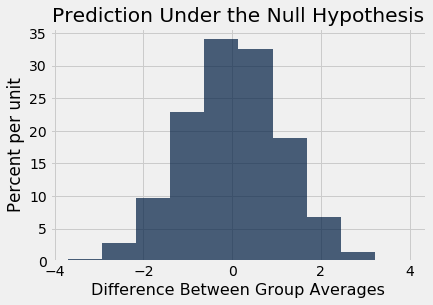

In [15]:
Table().with_column('Difference Between Group Averages', differences).hist()
print('Observed Difference:', observed_difference)
plots.title('Prediction Under the Null Hypothesis');

Notice how the distribution is centered around 0. This makes sense, because under the null hypothesis the two groups should have roughly the same average. Therefore the difference between the group averages should be around 0.

The observed difference in the original sample is about $-9.27$ ounces, which doesn't even appear on the horizontal scale of the histogram. The observed value of the statistic and the predicted behavior of the statistic under the null hypothesis are inconsistent. 

The conclusion of the test is that the data support the alternative more than they support the null. The average birth weight of babies born to mothers who smoke is less than the average birth weight of babies born to non-smokers.

If you want to compute an empirical P-value, remember that low values of the statistic favor the alternative hypothesis. 

In [16]:
empirical_P = np.count_nonzero(differences <= observed_difference) / repetitions
empirical_P

0.0

The empirical P-value is 0, meaning that none of the 5,000 observed samples resulted in a difference of -9.27 or lower. This is an approximation; the exact chance of getting a difference in that range is not 0 but it is vanishingly small.

### A Function to Simulate the Differences Under the Null Hypothesis ###
We will want to perform permutation tests for the difference between averages in other contexts as well. Let us define a function that generates the array of simulated differences, based on the code that we wrote above. That will save us time later.

The function `difference_of_permuted_sample_means` takes four arguments:
- the name of the data table
- the label of the column containing the variable whose average is of interest
- the label of the column of group labels
- the number of repetitions

It returns and array of simulated differences in group means, each computed by first randomly permuting the data and assigning random values to each group. The length of the array is equal to the number of repetitions.

In [17]:
def permuted_sample_average_difference(table, label, group_label, repetitions):
    
    tbl = table.select(group_label, label)
    
    differences = make_array()
    for i in np.arange(repetitions):
        shuffled = tbl.sample(with_replacement = False).column(1)
        original_and_shuffled = tbl.with_column('Shuffled Data', shuffled)

        shuffled_means = original_and_shuffled.group(group_label, np.average).column(2)
        simulated_difference = shuffled_means.item(1) - shuffled_means.item(0)
    
        differences = np.append(differences, simulated_difference)
    
    return differences   

As an example of the use of this function, we will test whether there was any difference in the ages of the smoking and non-smoking mothers. The histograms of the two distributions in the sample are a little different. The smokers seem a little younger on average.

/home/choldgraf/anaconda/envs/dev/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


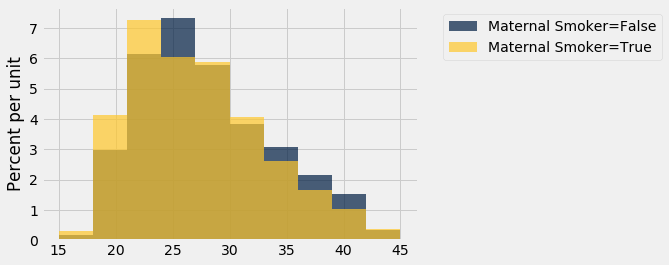

In [18]:
smoking_and_age = baby.select('Maternal Smoker', 'Maternal Age')
smoking_and_age.hist('Maternal Age', group = 'Maternal Smoker')

In [19]:
smoking_and_age.group('Maternal Smoker', np.average)

Maternal Smoker,Maternal Age average
False,27.5441
True,26.7364


The observed difference between the average ages is about $-0.8$ years.

In [20]:
observed_means = smoking_and_age.group('Maternal Smoker', np.average).column(1)
observed_difference = observed_means.item(1) - observed_means.item(0)
observed_difference

-0.8076725017901509

If the underlying distributions of ages in the two groups are the same, then the empirical distribution of the difference based on permuted samples will predict how the statistic will vary due to chance.

We can generate such differences using the function we just defined.

In [21]:
differences = permuted_sample_average_difference(baby, 'Maternal Age', 'Maternal Smoker', 5000)

The observed difference is in the tail of the empirical distribution of the differences simulated under the null hypothesis. 

Observed Difference: -0.8076725017901509


/home/choldgraf/anaconda/envs/dev/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


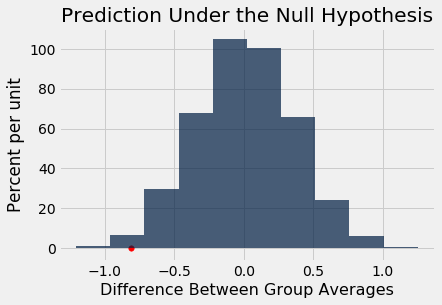

In [22]:
Table().with_column('Difference Between Group Averages', differences).hist()
plots.scatter(observed_difference, 0, color='red', s=30)
plots.title('Prediction Under the Null Hypothesis')
print('Observed Difference:', observed_difference)

The empirical P-value of the test is the proportion of simulated differences that were equal to or less than the observed difference. This is because low values of the difference favor the alternative hypothesis that the smokers were younger on average.

In [23]:
empirical_P = np.count_nonzero(differences <= observed_difference) / 5000
empirical_P

0.01

The empirical P-value is just over 1%, which is less than 5% and therefore the result is statistically significant. The test supports the hypothesis that the smokers were younger on average.